# Overview

In this notebook I develop the code necessary to prepare raw _Planet_ satellite 
images for the object detection model.The input if is a file/directory path. The file is loaded, clipped to the area of interest provided by the user, and then resized to a size appropriate for labeling by the model. The resized image dimensions are also provided by the user.

## Download Imagery


In [ ]:
# Imports here
import os

from google.cloud import storage

# Create the service client.
from googleapiclient.discovery import build
from apiclient.http import MediaIoBaseDownload

In [ ]:
# GOOGLE CREDS is different for notebook – change for .py files
GOOGLE_APPLICATION_CREDENTIALS = os.getenv('GOOGLE_APPLICATION_CREDENTIALS')
BUCKET_NAME = os.getenv('BUCKET_NAME')
GEO_FILTER_PATH = os.getenv('GEO_FILTER_PATH')
PATH_PREFIX = os.getenv('PATH_PREFIX')
ORDER_ID = os.getenv('ORDER_ID')
ITEM_TYPE = os.getenv('ITEM_TYPE')
ITEM_ID_PATH = os.getenv('ITEM_ID_PATH')
DL_IMAGE_PATH = os.getenv('DL_IMAGE_PATH')
BAND_ID = os.getenv('BAND_ID')

In [ ]:
def download_img(dl_path, id_num):
    gcs_service = build('storage', 'v1')
    if not os.path.exists(os.path.dirname(dl_path)):
        try:
            os.makedirs(os.path.dirname(dl_path))
        except OSError as exc: # Guard against race condition
            if exc.errno != errno.EEXIST:
                raise
    with open(dl_path, 'wb') as f:
      # Download the file from the Google Cloud Storage bucket.
      request = gcs_service.objects().get_media(bucket=BUCKET_NAME,
                                                object=dl_path)
      media = MediaIoBaseDownload(f, request)
      print('Downloading image ', id_num, '...')
      print('Download Progress: ')
      done = False
      while not done:
          prog, done = media.next_chunk()
          print(prog.progress())

    print('Image ', id_num, ' downloaded.')
    return dl_path

### Download model parameters dictionary

In [ ]:
%env BUCKET_NAME=model_params
BUCKET_NAME = os.getenv('BUCKET_NAME')

env: BUCKET_NAME=model_params


In [ ]:
dl_path = r'dicts/maskrcnn_resnet50_state_dict_4.pth'
download_img(dl_path, 0)

Download Progress: 
0.5951786407465112
1.0
Image  0  downloaded.


'dicts/maskrcnn_resnet50_state_dict_4.pth'

In [ ]:
%env BUCKET_NAME=planet_imagery
BUCKET_NAME = os.getenv('BUCKET_NAME')

env: BUCKET_NAME=planet_imagery


## Preprocess Imagery


In [ ]:
from google.cloud import storage
from skimage.util import view_as_blocks, pad
import math
import numpy as np

from osgeo import gdal, osr, ogr


In [ ]:
!pip3 install geojson

In [ ]:
import geojson as gj
import json
from osgeo import ogr, osr, gdal
import matplotlib.pyplot as plt


def plot_img(img_array):
    fig,ax = plt.subplots(1, figsize=(2,2))
    # Display the image
    ax.imshow(img_array)

# Enable GDAL/OGR exceptions
gdal.UseExceptions()


# GDAL & OGR memory drivers
GDAL_MEMORY_DRIVER = gdal.GetDriverByName('MEM')
OGR_MEMORY_DRIVER = ogr.GetDriverByName('Memory')


def get_geo_info(ds):
    xoff, a, b, yoff, d, e = ds.GetGeoTransform()

    # Get projection information from source image
    ds_proj = ds.GetProjectionRef()
    ds_srs = osr.SpatialReference(ds_proj)

    # Get the source image's geographic coordinate system (the 'GEOGCS' node of ds_srs)
    geogcs = ds_srs.CloneGeogCS()

    # Set up a transformation between projected coordinates (x, y) & geographic coordinates (lat, lon)
    transform = osr.CoordinateTransformation(ds_srs, geogcs)
    return (xoff, a, b, yoff, d, e), transform


def load_img(img_path):
  '''Returns both the relevant geographic data, and other metadata such as
   cloudcover etc. and the img itself as a numpy array.
  '''
  ds = gdal.Translate('',
                img_path,
                options='-ot Byte -scale minval maxval -of MEM')
  (xoff, a, b, yoff, d, e), transform = get_geo_info(ds)
  return ds, (xoff, a, b, yoff, d, e), transform


def cut_by_geojson(input_file, output_file, shape_geojson):
    # Get coords for bounding box
    reader = ogr.Open(shape_geojson)
    layer = reader.GetLayer()
    feature = layer.GetFeature(0)
    geoms = json.loads(feature.ExportToJson())['geometry']
    x, y = zip(*gj.utils.coords(geoms))

    min_x, max_x, min_y, max_y = min(x), max(x), min(y), max(y)

    # Open original data as read only
    dataset = gdal.Open(input_file, gdal.GA_ReadOnly)

    bands = dataset.RasterCount

    # Getting georeference info
    transform = dataset.GetGeoTransform()
    projection = dataset.GetProjection()
    xOrigin = transform[0]
    yOrigin = transform[3]
    pixelWidth = transform[1]
    pixelHeight = -transform[5]

    # Getting spatial reference of input raster
    srs = osr.SpatialReference()
    srs.ImportFromWkt(projection)

    # WGS84 projection reference
    OSR_WGS84_REF = osr.SpatialReference()
    OSR_WGS84_REF.ImportFromEPSG(4326)

    # OSR transformation
    wgs84_to_image_trasformation = osr.CoordinateTransformation(OSR_WGS84_REF,
                                                                srs)
    XYmin = wgs84_to_image_trasformation.TransformPoint(min_x, max_y)
    XYmax = wgs84_to_image_trasformation.TransformPoint(max_x, min_y)

    # Computing Point1(i1,j1), Point2(i2,j2)
    i1 = int((XYmin[0] - xOrigin) / pixelWidth)
    j1 = int((yOrigin - XYmin[1]) / pixelHeight)
    i2 = int((XYmax[0] - xOrigin) / pixelWidth)
    j2 = int((yOrigin - XYmax[1]) / pixelHeight)
    new_cols = i2 - i1 + 1
    new_rows = j2 - j1 + 1

    # New upper-left X,Y values
    new_x = xOrigin + i1 * pixelWidth
    new_y = yOrigin - j1 * pixelHeight
    new_transform = (new_x, transform[1], transform[2], new_y, transform[4],
                     transform[5])

    wkt_geom = ogr.CreateGeometryFromJson(str(geoms))
    wkt_geom.Transform(wgs84_to_image_trasformation)

    target_ds = GDAL_MEMORY_DRIVER.Create('', new_cols, new_rows, 1,
                                          gdal.GDT_Byte)
    target_ds.SetGeoTransform(new_transform)
    target_ds.SetProjection(projection)

    # Create a memory layer to rasterize from.
    ogr_dataset = OGR_MEMORY_DRIVER.CreateDataSource(shape_geojson)
    ogr_layer = ogr_dataset.CreateLayer(shape_geojson, srs=srs)
    ogr_feature = ogr.Feature(ogr_layer.GetLayerDefn())
    ogr_feature.SetGeometryDirectly(ogr.Geometry(wkt=wkt_geom.ExportToWkt()))
    ogr_layer.CreateFeature(ogr_feature)

    gdal.RasterizeLayer(target_ds, [1], ogr_layer, burn_values=[1],
                        options=["ALL_TOUCHED=TRUE"])

    # Create output file
    driver = gdal.GetDriverByName('GTiff')
    outds = driver.Create(output_file, new_cols, new_rows, bands,
                          gdal.GDT_Float32)

    # Read in bands and store all the data in bandList
    mask_array = target_ds.GetRasterBand(1).ReadAsArray()
    band_list = []

    for i in range(bands):
        band_list.append(dataset.GetRasterBand(i + 1).ReadAsArray(i1, j1,
                         new_cols, new_rows))

    for j in range(bands):
        data = np.where(mask_array == 1, band_list[j], mask_array)
        outds.GetRasterBand(j + 1).SetNoDataValue(0)
        outds.GetRasterBand(j + 1).WriteArray(data)

    outds.SetProjection(projection)
    outds.SetGeoTransform(new_transform)

    target_ds = None
    dataset = None
    outds = None
    ogr_dataset = None

    return output_file


def clip_img(ds, img_path, aoi, coords, transform, plot_image=False,
             verbose=False):
  (xoff, a, b, yoff, d, e) = coords
  if aoi is not None:
      outpath = r'/clipped/' + img_path
      if not os.path.exists(os.path.dirname(outpath)):
          try:
              os.makedirs(os.path.dirname(outpath))
          except OSError as exc: # Guard against race condition
              if exc.errno != errno.EEXIST:
                  raise
      # Make gdal options
      if verbose:
        print('Clipping image...')
      new_img_path = cut_by_geojson(img_path, outpath, aoi)
      if verbose:
        print('Image clipped.')
      ds = gdal.Translate('',
                new_img_path,
                options='-ot Byte -scale minval maxval -of MEM')
      (xoff, a, b, yoff, d, e), transform = get_geo_info(ds)

  b1, b2, b3, b4 = (ds.GetRasterBand(1).ReadAsArray(), 
                  ds.GetRasterBand(2).ReadAsArray(), 
                  ds.GetRasterBand(3).ReadAsArray(), 
                  ds.GetRasterBand(4).ReadAsArray())
  img_array = np.array((b3,b2,b1))
  img_array = np.moveaxis(img_array, 0, 2)

  if plot_image:
    plot_img(img_array)
  
  return img_array, (xoff, a, b, yoff, d, e), transform


def split_img(img_array, patch_shape=None, xoffset=0, yoffset=0):
  if patch_shape is None:
    return img_array
  img_shape = img_array.shape
  width, height = img_shape[:2]
  patch_width, patch_height = patch_shape[:2]
  width_remainder = width % patch_width
  height_remainder = height % patch_height

  pad_w = patch_width - width_remainder
  pad_h = patch_height - height_remainder

  half_pad_w = pad_w / 2
  half_pad_w_1 = int(math.ceil(half_pad_w))
  half_pad_w_2 = int(math.floor(half_pad_w))

  half_pad_h = pad_h / 2
  half_pad_h_1 = int(math.ceil(half_pad_h))
  half_pad_h_2 = int(math.floor(half_pad_h))
    
  img_padded = np.pad(img_array, 
                    [[half_pad_w_1, half_pad_w_2], 
                     [half_pad_h_1, half_pad_h_2], 
                     [0, 0]],
                    'constant', constant_values=(0))
  patches = view_as_blocks(img_padded, patch_shape)

  n_horz_patches = patches.shape[1] # Number of patches along x-axis
  n_ver_patches = patches.shape[0] # Number of patches along y-axis

  for i in range(n_ver_patches):
    my = i * patch_height - half_pad_h_1 + yoffset
    for j in range(n_horz_patches):
      mx = j * patch_width - half_pad_w_1 + xoffset
      yield (i, j), patches[i, j, :, :, :, :], mx, my


def get_img_paths(dirpath, bucket_name, dl=True, max_num_imgs=None, skip_first=0):
  client = storage.Client()
  id = 0
  for blob in client.list_blobs(bucket_name, prefix=dirpath):
    if max_num_imgs is not None:
      if id > max_num_imgs - 1:
        break
    filepath = blob.name
    if filepath[-14:] == 'AnalyticMS.tif':
      if id < skip_first:
        id += 1
        continue
      if dl == True:
        download_img(filepath, id)
        id += 1
      yield filepath



def prep_imgs(dirpath, bucketname, patch_shape=None, aoi=None, id_start_idx=55, 
              id_end_idx=-18, max_num_imgs=25, skip_first=0, plot_image=False, print_clip=False):
    img_paths = get_img_paths(dirpath, bucketname, max_num_imgs=max_num_imgs + skip_first, skip_first=skip_first)
    idx = 0
    for img_path in img_paths:
        item_id = img_path[id_start_idx:id_end_idx]
        ds, (xoff, a, b, yoff, d, e), transform = load_img(img_path)
        img_clipped, (xoff, a, b, yoff, d, e), transform = clip_img(ds, img_path, 
                                                                    aoi, 
                                                                    (xoff, a, b, yoff, d, e), 
                                                                    transform,
                                                                    plot_image,
                                                                    verbose=print_clip)
        if patch_shape is None:
            return img_clipped, item_id, None, (xoff, a, b, yoff, d, e), transform
        imgs_split = split_img(img_clipped, patch_shape)
        for (i, j), split, mx, my in imgs_split:
            subsample_id = str(i) + '_' + str(j)
            yield split[0,:,:,:], item_id, subsample_id, (xoff, a, b,
                                                          yoff, d, e), \
                                                          transform, mx, my

## Load Model

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [ ]:
import torch
from torchvision.transforms import functional as F



state_dict = r'/content/dicts/maskrcnn_resnet50_state_dict_4.pth'
#state_dict = r'/content/maskrcnn_resnet50_state_dict.pth'

model = get_instance_segmentation_model(2)
model.load_state_dict(torch.load(state_dict))

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


<All keys matched successfully>

In [ ]:
device = torch.device('cuda')
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample): 

## Process Results

In [ ]:
import pandas as pd

from datetime import datetime
from osgeo import gdal, osr, ogr


def make_df(rows=None):
    col_names = ['target_id', 'item_id', 'datetime', 'probability', 'latitude', 'longitude',
                'bounding_box', 'area', 'major_length', 'minor_length']
    df = pd.DataFrame(columns=col_names)
    #df.set_index('target_id')
    if rows is not None:
          df = df.append(rows)
    return df


def get_datetime(item_id):
    datetime_str = item_id[:15]
    datetime_obj = datetime.strptime(datetime_str, '%Y%m%d_%H%M%S')
    return datetime_obj


def get_bboxes(prediction, thresh=0.5):
    '''Selects only those bounding boxes associated with 
    probabilities greater than threshold.
    '''
    scores =  prediction['scores'].cpu().numpy()
    filtered_idx = np.where(scores > thresh)
    bboxes = prediction['boxes'].cpu().numpy()
    bboxes = bboxes[filtered_idx]
    return list(zip(scores[filtered_idx], bboxes))


def convert_px_to_lat_long(results, coords, transform, mx, my, xadj=330, yadj=-330):
    xoff, a, b, yoff, d, e = coords
    lat_long_list = []
    for _, bbox in results:
        x0, y0, x1, y1 = bbox
        center_x = x0 + ((x1 - x0) / 2)
        center_y = y0 + ((y1 - y0) / 2)
        
        # Get global coordinates from pixel x, y coords
        #projected_x = a * center_x + a * mx + xoff + b * center_y 
        #projected_y = d * center_y + d * my + yoff + e * center_y
        projected_x = a * (center_x + mx) + b * (center_y + my) + xoff + xadj
        projected_y = d * (center_x + mx) + e * (center_y + my) + yoff + yadj

        # Transform from projected x, y to geographic lat, lng
        lng, lat, _ = transform.TransformPoint(projected_x, projected_y)
        lat_long_list.append((lat, lng))
    return lat_long_list


def format_rows(rows, datetime, item_id, subsample_id, m_per_pix=3.0):
    row_list = []
    for idx, target in enumerate(rows):
        target_id = item_id + '_'  + subsample_id + '_' + str(idx)
        probability = target[0][0]
        latitude = target[1][0]
        longitude = target[1][1]

        bounding_box = target[0][1]
        x0, y0, x1, y1 = bounding_box
        diff_y = (y1 - y0) * m_per_pix
        diff_x = (x1 - x0) * m_per_pix
        area = diff_y * diff_x
        major_length = max(diff_y, diff_x)
        minor_length = min(diff_y, diff_x)

        row_list.append({'target_id':target_id, 'item_id':item_id, 'datetime':datetime, 
                   'probability':probability, 'latitude':latitude, 'longitude':longitude, 
                   'bounding_box':bounding_box, 'area':area, 'major_length':major_length, 
                   'minor_length':minor_length}) #ignore_index=True)
    return row_list
        
        
def process_outputs(prediction, item_id, subsample_id, coords, transform, mx, my,
                    thresh=0.5, m_per_pix=3.0):
    if prediction[0]['scores'].cpu().numpy().shape[0] < 1:
        return
    datetime = get_datetime(item_id)    
    results = get_bboxes(prediction[0], thresh)
    rows = list(zip(results, convert_px_to_lat_long(results, 
                                                    coords, 
                                                    transform, mx, my)))
    rows = format_rows(rows, datetime, item_id, subsample_id, m_per_pix=m_per_pix)
    return rows

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

def plot_bbox(prediction, img, thresh=0.5):
    bbox_list = get_bboxes(prediction[0], thresh)
    if len(bbox_list) < 1:
        return 

    # Create figure and axes
    fig,ax = plt.subplots(1, figsize=(10,10))

    # Display the image
    ax.imshow(img)


    for _, bbox in get_bboxes(prediction[0], thresh):
        x0, y0, x1, y1 = bbox
        
        center_x = x0 + ((x1 - x0) / 2)
        center_y = y0 + ((y1 - y0) / 2)
        # Create a Rectangle patch
        rect = patches.Rectangle((x0, y0), x1-x0, y1-y0,linewidth=1,edgecolor='r',facecolor='none')
        
        # Add the patch to the Axes
        ax.add_patch(rect)
        plt.scatter(center_x, center_y,color='r')

    plt.show()

# Tests

In [ ]:
from datetime import datetime

if __name__ == '__main__':
  thresh=0.20
  dirpath = r'lima/2a2ca315-88af-4c4f-be1d-befdab5ce7fa/PSScene4Band'
  #aoi = r'/content/map_5.geojson'
  aoi = None
  imgs = prep_imgs(dirpath, BUCKET_NAME, (768, 768, 3), aoi=aoi, id_start_idx=55, id_end_idx=-18,
                   max_num_imgs=50, skip_first=50, plot_image=False, print_clip=True)
  rows = []
  model.eval()
  for img, item_id, subsample_id, (xoff, a, b, yoff, d, e), transform, mx, my in imgs:
    # Label the image
    image = F.to_tensor(img)
    with torch.no_grad():
      try:
        prediction = model([(image).to(device)])
      except RuntimeError:
        print('RuntimeError occured. Skipping image.')
        continue
    # Add data to df list
    new_rows = process_outputs(prediction, item_id, subsample_id, 
                               (xoff, a, b, yoff, d, e), transform, mx, my,
                               thresh=thresh)
    if new_rows is not None:
      #plot_bbox(prediction, img, thresh=thresh)
      rows += new_rows
  df = make_df(rows)

Download Progress: 
0.6725910231918872
1.0
Image  50  downloaded.


/usr/local/lib/python3.6/dist-packages/torchvision/ops/boxes.py:101: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  keep = keep.nonzero().squeeze(1)


Download Progress: 
0.7275054989115267
1.0
Image  51  downloaded.
Download Progress: 
0.7437519189146313
1.0
Image  52  downloaded.
Download Progress: 
0.625514810287803
1.0
Image  53  downloaded.
Download Progress: 
0.623432567209572
1.0
Image  54  downloaded.
Download Progress: 
0.6353189802003999
1.0
Image  55  downloaded.
Download Progress: 
0.6200586196465012
1.0
Image  56  downloaded.
Download Progress: 
0.7055253547700964
1.0
Image  57  downloaded.
Download Progress: 
0.5551797849449248
1.0
Image  58  downloaded.
Download Progress: 
0.742323122992404
1.0
Image  59  downloaded.
Download Progress: 
0.7546893725069886
1.0
Image  60  downloaded.
Download Progress: 
0.5865712160066204
1.0
Image  61  downloaded.
Download Progress: 
0.5981206728022421
1.0
Image  62  downloaded.
Download Progress: 
0.9182412347945764
1.0
Image  63  downloaded.
Download Progress: 
0.6005977510553459
1.0
Image  64  downloaded.
Download Progress: 
0.6216531635720128
1.0
Image  65  downloaded.
Download Prog

In [ ]:
len(rows)

6771

## Merge DFs

In [ ]:
#frames = [df_filtered, df]
#df = pd.concat(frames)

In [ ]:
df.shape[0]

6771

# Make map

In [ ]:
!pip install gmaps

     |████████████████████████████████| 1.1MB 6.9MB/s 
  Created wheel for gmaps: filename=gmaps-0.9.0-py2.py3-none-any.whl size=2076096 sha256=5e266234a77de3a56c48183c694b29c23d334a1e998e6cbe66a7edc7784fcfd2
  Stored in directory: /root/.cache/pip/wheels/33/eb/41/5302168c36fc8ce8f48143bb58fde1015d5bc0c62bc3ddbb38
Successfully built gmaps


In [ ]:
# Imports
import numpy as np 
import pandas as pd 
import gmaps 
import gmaps.datasets 
import datetime

## Filter points on land

In [ ]:
import json
from shapely.geometry import shape, Point


def filter_fn(row, aoi):
    point = Point(row.longitude, row.latitude)

    # check each polygon to see if it contains the point
    for feature in aoi['features']:
        polygon = shape(feature['geometry'])
        if polygon.contains(point):
            return True
    return False


def filter_fn_neg(row, aoi):
    point = Point(row.longitude, row.latitude)

    # check each polygon to see if it contains the point
    for feature in aoi['features']:
        polygon = shape(feature['geometry'])
        if polygon.contains(point):
            return False
    return True

In [ ]:
# load GeoJSON file containing sectors
with open('/content/callao_final.geojson') as f:
    aoi_1 = json.load(f)
with open('/content/callao_island.geojson') as f:
    aoi_2 = json.load(f)

select_rows = df.apply(filter_fn, axis=1, aoi=aoi_1)
df_filtered = df[select_rows]

select_rows = df_filtered.apply(filter_fn_neg, axis=1, aoi=aoi_2)
df_filtered = df_filtered[select_rows]

In [ ]:
df_filtered.shape[0]

3536

In [ ]:
df.shape[0]

6771

## Prepare for Maps

In [ ]:
api_key = 'API KEY HERE'
gmaps.configure(api_key=api_key)

In [ ]:
heatmap_data = {'latitude': df_filtered.latitude, 'longitude' : df_filtered.longitude} 
#heatmap_data = {'latitude': df.latitude, 'longitude' : df.longitude} 
maps_data = pd.DataFrame(data=heatmap_data)

In [ ]:
locations = maps_data[['latitude', 'longitude']]
fig = gmaps.figure() 
heatmap_layer = gmaps.heatmap_layer(locations) 
fig.add_layer(heatmap_layer) 
fig

Figure(layout=FigureLayout(height='420px'))

In [ ]:
from ipywidgets.embed import embed_minimal_html
import IPython


embed_minimal_html('/content/callao_vessel_map.html', views=[fig])

IPython.display.HTML(filename='/content/callao_vessel_map.html')

## Make timeseries graphs

In [ ]:
import matplotlib.pyplot as plt

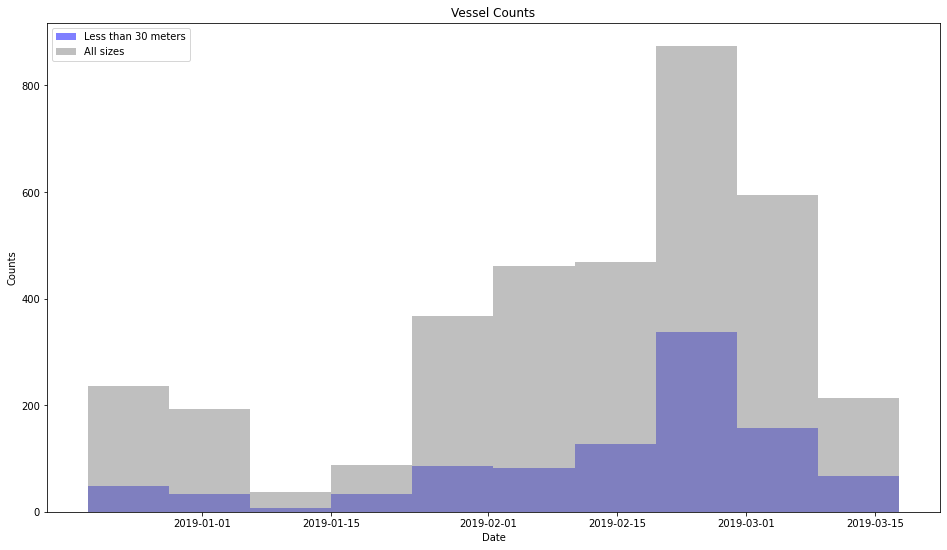

In [ ]:
datetimes_less_30 = df_filtered[df_filtered.major_length < 30]['datetime']
datetimes = df_filtered['datetime']
fig, ax = plt.subplots(1,1, figsize=(16, 9))
ax.hist(datetimes_less_30, alpha=0.5, label='Less than 30 meters', color='blue')
ax.hist(datetimes, alpha=0.5, label='All sizes', color='grey')
ax.set_title('Vessel Counts')
ax.set_xlabel('Date')
ax.set_ylabel('Counts')
plt.legend(loc='upper left')
plt.show()
fig.savefig('vessel_counts_graph.png')


## Download files

In [ ]:
from google.colab import files


files.download('/content/vessel_counts_graph.png')
files.download('/content/callao_vessel_map.html')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>